Импортируем необходимые вещи и определяем функции с говорящими названиями

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from sklearn.metrics import roc_auc_score as rocauc
from sklearn.metrics import accuracy_score as acc
from __future__ import print_function  
import seaborn as sns
sns.set_style("whitegrid")

np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)
input_shape = (28, 28, 1)

def printimg(tensor):
    image = tensor[:,:,0]
    plt.imshow(image,aspect="auto")
    plt.show()
    
def D1_problem_to_C1_problem(arr):
    arr = (arr - beta/(alpha + beta))*(((1 - beta) / (2 - alpha - beta) - beta / (alpha + beta)) ** -1)
    arr = np.clip(arr,0,1) # значение недообученного классификатора на предыдущем этапе может выйти за границы 0 и 1 
    return arr

Using TensorFlow backend.


Загружаем датасет:

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.append(x_train, x_test, axis=0)
y = np.append(y_train, y_test)
x = x.reshape(x.shape[0], 28, 28, 1)

Задаём параметры эксперимента:

In [3]:
C0_values = [0] # Какие цифры допустимы в классе C_0. В классе C_1 будут все остальные цифры 
_NUMBER_OF_C0_IN_D0 = 5
_NUMBER_OF_C0_IN_D1 = 900
_NUMBER_OF_C1_IN_D0 = 20000
_NUMBER_OF_C1_IN_D1 = 20000

Выделяем из датасета элементы в необходимых пропорциях, расставляем лейблы:

In [4]:
y_C1 = np.array([int(elem not in C0_values) for elem in y])
_TOTAL_NUMBER_OF_C0 = len(y) - y_C1.sum()

alpha = _NUMBER_OF_C0_IN_D0 / (_NUMBER_OF_C0_IN_D0 + _NUMBER_OF_C1_IN_D0)
beta = _NUMBER_OF_C0_IN_D1 / (_NUMBER_OF_C0_IN_D1 + _NUMBER_OF_C1_IN_D1)

NUMBER_OF_C0_IN_D0 = _NUMBER_OF_C0_IN_D0
NUMBER_OF_C0_IN_D1 = _NUMBER_OF_C0_IN_D1
NUMBER_OF_C1_IN_D0 = _NUMBER_OF_C1_IN_D0
NUMBER_OF_C1_IN_D1 = _NUMBER_OF_C1_IN_D1

y_D1 = []
i=0
X = []
Y_C1 = []
Y_D1 = []

while (NUMBER_OF_C0_IN_D0, NUMBER_OF_C0_IN_D1, NUMBER_OF_C1_IN_D0, NUMBER_OF_C1_IN_D1) != (0,0,0,0):
    if y_C1[i] == 1 and NUMBER_OF_C1_IN_D0 != 0:
        Y_C1.append(1)
        Y_D1.append(0)
        X.append(x[i])
        NUMBER_OF_C1_IN_D0 -= 1
        i += 1
    elif y_C1[i] == 0 and NUMBER_OF_C0_IN_D0 != 0:
        Y_C1.append(0)
        Y_D1.append(0)
        X.append(x[i])
        NUMBER_OF_C0_IN_D0 -= 1
        i += 1
    elif y_C1[i] == 1 and NUMBER_OF_C1_IN_D1 != 0:
        Y_C1.append(1)
        Y_D1.append(1)
        X.append(x[i])
        NUMBER_OF_C1_IN_D1 -= 1
        i += 1
    elif y_C1[i] == 0 and NUMBER_OF_C0_IN_D1 != 0:
        Y_C1.append(0)
        Y_D1.append(1)
        X.append(x[i])
        NUMBER_OF_C0_IN_D1 -= 1
        i += 1
    else:
        i += 1
X = np.array(X)
Y_C1 = np.array(Y_C1)
Y_D1 = np.array(Y_D1)

Бьём на train/test:

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_C1_train, Y_C1_test, Y_D1_train, Y_D1_test = train_test_split(X, 
                                                                                 np.expand_dims(Y_C1, axis=1), 
                                                                                 np.expand_dims(Y_D1, axis=1), 
                                                                                 test_size=0.3, 
                                                                                 random_state=0)

Определяем лог.регресию и CNN

In [24]:
logreg = Sequential()
logreg.add(Flatten(input_shape=input_shape))
logreg.add(Dense(1, activation='sigmoid'))
logreg.compile(loss=keras.losses.binary_crossentropy,
               optimizer=keras.optimizers.Adam())

cnn = Sequential()
cnn.add(Conv2D(8, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn.add(Conv2D(16, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss=keras.losses.binary_crossentropy,
                        optimizer=keras.optimizers.Adam())

Учим лог.регрессию

In [25]:
t0=time()

In [26]:
saver_logreg = keras.callbacks.ModelCheckpoint(filepath='/tmp/logreg.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
lr_decreaser_logreg = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.1, epsilon=0.001, verbose=1)

logreg.fit(X_train, Y_D1_train, validation_data = (X_test, Y_D1_test),
           verbose=1, batch_size=5000, epochs=200, 
           callbacks=[saver_logreg, lr_decreaser_logreg])

Train on 28633 samples, validate on 12272 samples
Epoch 1/200
28633/28633 [==============================] - 0s - loss: 7.6987 - val_loss: 7.7314
Epoch 2/200
28633/28633 [==============================] - 0s - loss: 7.6346 - val_loss: 7.6691
Epoch 3/200
28633/28633 [==============================] - 0s - loss: 7.5438 - val_loss: 7.6198
Epoch 4/200
28633/28633 [==============================] - 0s - loss: 7.4625 - val_loss: 7.5658
Epoch 5/200
28633/28633 [==============================] - 0s - loss: 7.3820 - val_loss: 7.5528
Epoch 6/200
28633/28633 [==============================] - 0s - loss: 7.3294 - val_loss: 7.4349
Epoch 7/200
28633/28633 [==============================] - 0s - loss: 7.1881 - val_loss: 7.3092
Epoch 8/200
28633/28633 [==============================] - 0s - loss: 7.0521 - val_loss: 7.1609
Epoch 9/200
28633/28633 [==============================] - 0s - loss: 6.9108 - val_loss: 7.0083
Epoch 10/200
28633/28633 [==============================] - 0s - loss: 6.7858 - val_lo

28633/28633 [==============================] - 0s - loss: 2.1558 - val_loss: 2.3885
Epoch 66/200
28633/28633 [==============================] - 0s - loss: 2.0784 - val_loss: 2.2764
Epoch 67/200
28633/28633 [==============================] - 0s - loss: 1.9929 - val_loss: 2.1419
Epoch 68/200
28633/28633 [==============================] - 0s - loss: 1.9384 - val_loss: 2.2576
Epoch 69/200
28633/28633 [==============================] - 0s - loss: 1.9799 - val_loss: 2.1983
Epoch 70/200
28633/28633 [==============================] - 0s - loss: 2.0421 - val_loss: 2.3720
Epoch 71/200
28633/28633 [==============================] - 0s - loss: 2.0341 - val_loss: 1.9621
Epoch 72/200
28633/28633 [==============================] - 0s - loss: 1.7729 - val_loss: 1.8565
Epoch 73/200
28633/28633 [==============================] - 0s - loss: 1.7432 - val_loss: 1.7889
Epoch 74/200
28633/28633 [==============================] - 0s - loss: 1.6441 - val_loss: 1.7476
Epoch 75/200
28633/28633 [=================

28633/28633 [==============================] - 0s - loss: 1.0691 - val_loss: 1.3919
Epoch 102/200
28633/28633 [==============================] - 0s - loss: 1.1080 - val_loss: 1.2155
Epoch 103/200
28633/28633 [==============================] - 0s - loss: 1.0292 - val_loss: 0.9965
Epoch 104/200
28633/28633 [==============================] - 0s - loss: 0.9300 - val_loss: 1.1240
Epoch 105/200
28633/28633 [==============================] - 0s - loss: 1.0191 - val_loss: 1.0401
Epoch 106/200
28633/28633 [==============================] - 0s - loss: 1.0229 - val_loss: 1.0195
Epoch 107/200
28633/28633 [==============================] - 0s - loss: 0.9283 - val_loss: 0.9513
Epoch 108/200
28633/28633 [==============================] - 0s - loss: 0.9044 - val_loss: 1.2827
Epoch 109/200
28633/28633 [==============================] - 0s - loss: 0.9871 - val_loss: 0.9565
Epoch 110/200
28633/28633 [==============================] - 0s - loss: 1.0062 - val_loss: 0.9338
Epoch 111/200
28633/28633 [=======

28633/28633 [==============================] - 0s - loss: 0.6850 - val_loss: 0.7320
Epoch 177/200
28633/28633 [==============================] - 0s - loss: 0.6851 - val_loss: 0.7307
Epoch 178/200
28633/28633 [==============================] - 0s - loss: 0.6851 - val_loss: 0.7299
Epoch 179/200
28633/28633 [==============================] - 0s - loss: 0.6849 - val_loss: 0.7303
Epoch 180/200
28633/28633 [==============================] - 0s - loss: 0.6848 - val_loss: 0.7311
Epoch 181/200
28633/28633 [==============================] - 0s - loss: 0.6847 - val_loss: 0.7298
Epoch 182/200
28633/28633 [==============================] - 0s - loss: 0.6845 - val_loss: 0.7298
Epoch 183/200
28633/28633 [==============================] - 0s - loss: 0.6845 - val_loss: 0.7292
Epoch 184/200
28633/28633 [==============================] - 0s - loss: 0.6843 - val_loss: 0.7294
Epoch 185/200
28633/28633 [==============================] - 0s - loss: 0.6844 - val_loss: 0.7300
Epoch 186/200
28633/28633 [=======

Учим CNN на лейблах - предиктах логрегрессии

In [27]:
saver_cnn = keras.callbacks.ModelCheckpoint(filepath='/tmp/cnn_old.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
lr_decreaser_cnn = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, epsilon=0.001, verbose=1)

logreg.load_weights('/tmp/logreg.hdf5')

cnn.fit(X_train, logreg.predict(X_train), validation_data = (X_test, Y_D1_test),
                    verbose=1, epochs=1,
                    callbacks=[saver_cnn, lr_decreaser_cnn])

Train on 28633 samples, validate on 12272 samples
Epoch 1/1
28633/28633 [==============================] - 56s - loss: 1.3817 - val_loss: 0.6895


In [28]:
print('логрег + кнн тренировались столько: ', time() - t0)

логрег + кнн тренировались столько:  105.20178413391113


In [29]:
cnn_pure = Sequential()
cnn_pure.add(Conv2D(8, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_pure.add(Conv2D(16, (3, 3), activation='relu'))
cnn_pure.add(MaxPooling2D(pool_size=(2, 2)))
cnn_pure.add(Dropout(0.25))
cnn_pure.add(Flatten())
cnn_pure.add(Dense(64, activation='relu'))
cnn_pure.add(Dropout(0.5))
cnn_pure.add(Dense(1, activation='sigmoid'))
cnn_pure.compile(loss=keras.losses.binary_crossentropy,
                        optimizer=keras.optimizers.Adam())

In [30]:
t0=time()

In [31]:
saver_cnn_pure = keras.callbacks.ModelCheckpoint(filepath='/tmp/cnn_new.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
lr_decreaser_cnn_pure = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, epsilon=0.001, verbose=1)


cnn_pure.fit(X_train, Y_D1_train, validation_data = (X_test, Y_D1_test),
                    verbose=1, epochs=2,
                    callbacks=[saver_cnn_pure, lr_decreaser_cnn_pure])

Train on 28633 samples, validate on 12272 samples
Epoch 1/2
28633/28633 [==============================] - 56s - loss: 5.8172 - val_loss: 0.6930
Epoch 2/2
28633/28633 [==============================] - 57s - loss: 0.6927 - val_loss: 0.6921


In [32]:
print('чистая кнн тренировалась столько: ', time() - t0)

чистая кнн тренировалась столько:  115.10945248603821


Предиктим D0 vs D1:

In [33]:
cnn.load_weights('/tmp/cnn_old.hdf5')
cnn_pure.load_weights('/tmp/cnn_new.hdf5')
logreg.load_weights('/tmp/logreg.hdf5')
Y_pred_cnn = cnn.predict(x)
Y_pred_logreg = logreg.predict(x)
Y_pred_cnn_pure = cnn_pure.predict(x)

Смотрим на распределения вероятностей для класса C_1

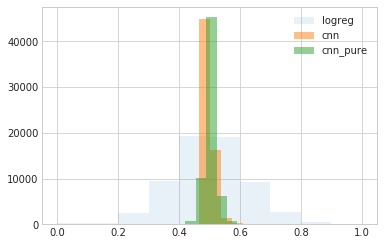

In [34]:
mask = [i for i,elem in enumerate(y_C1) if elem == 1]
plt.hist(Y_pred_logreg[mask], bins=10, alpha=0.1, label='logreg')
plt.hist(Y_pred_cnn[mask], bins=12, alpha=0.5, label='cnn')
plt.hist(Y_pred_cnn_pure[mask], bins=12, alpha=0.5, label='cnn_pure')
plt.legend(loc='upper right')
plt.show()

Смотрим на распределения вероятностей для класса C_0

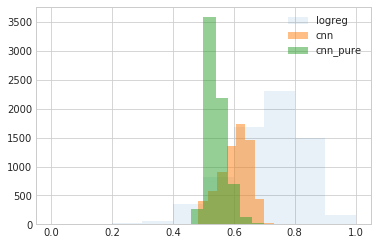

In [35]:
mask = [i for i,elem in enumerate(y_C1) if elem == 0]
plt.hist(Y_pred_logreg[mask], bins=10, alpha=0.1, label='logreg')
plt.hist(Y_pred_cnn[mask], bins=10, alpha=0.5, label='cnn')
plt.hist(Y_pred_cnn_pure[mask], bins=10, alpha=0.5, label='cnn_pure')
plt.legend(loc='upper right')
plt.show()

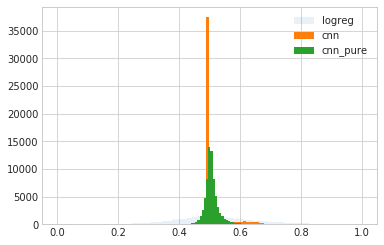

In [36]:
mask = [i for i,elem in enumerate(y_C1)]
plt.hist(Y_pred_logreg[mask], bins=160, alpha=0.1, label='logreg')
plt.hist(Y_pred_cnn[mask], bins=60, alpha=1, label='cnn')
plt.hist(Y_pred_cnn_pure[mask], bins=60, alpha=1, label='cnn_pure')
plt.legend(loc='upper right')
plt.show()

Рокауки на задаче C0 vs C1

In [37]:
print('logreg rocauc:', rocauc(Y_C1_test, D1_problem_to_C1_problem(logreg.predict(X_test)).flat))
print('cnn rocauc:', rocauc(Y_C1_test, D1_problem_to_C1_problem(cnn.predict(X_test)).flat))
print('cnn_pure rocauc:', rocauc(Y_C1_test, D1_problem_to_C1_problem(cnn_pure.predict(X_test)).flat))

logreg rocauc: 0.889860990557
cnn rocauc: 0.976458356035
cnn_pure rocauc: 0.873324302761
